In [1]:
import torch
import torch.nn as nn

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv("../Data/NYCTaxiFares.csv")

In [4]:
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2010-04-19 08:17:56 UTC,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1
1,2010-04-17 15:43:53 UTC,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1
2,2010-04-17 11:23:26 UTC,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2
3,2010-04-11 21:25:03 UTC,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1
4,2010-04-17 02:19:01 UTC,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1


In [5]:
df['fare_class'].value_counts()

0    80000
1    40000
Name: fare_class, dtype: int64

In [6]:
df['EDTdate'] = pd.to_datetime(df['pickup_datetime']) - pd.Timedelta(hours=4)

In [7]:
def haversine_distance(df, lat1, long1, lat2, long2):
    """
    Calculates the haversine distance between 2 sets of GPS coordinates in df
    """
    r = 6371  # average radius of Earth in kilometers
       
    phi1 = np.radians(df[lat1])
    phi2 = np.radians(df[lat2])
    
    delta_phi = np.radians(df[lat2]-df[lat1])
    delta_lambda = np.radians(df[long2]-df[long1])
     
    a = np.sin(delta_phi/2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    d = (r * c) # in kilometers

    return d

In [8]:
df['dist_km'] = haversine_distance(df, 'pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude')

In [9]:
df['Hour'] = df['EDTdate'].dt.hour

In [10]:
df['AMorPM'] = np.where(df['Hour'] < 12, 'am','pm')

In [11]:
df['Weekday'] = df['EDTdate'].dt.strftime("%a")

In [12]:
cat_cols = ['Hour','AMorPM','Weekday']

In [13]:
for field in cat_cols:
    df[field] = df[field].astype('category')

In [14]:
con_cols = ['pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count', 'dist_km']

In [15]:
cats = np.stack([df[cat].cat.codes.values for cat in cat_cols], axis=1)

In [16]:
cons = np.stack([df[con].values for con in con_cols], axis=1)

In [17]:
cat_sizes = [len(df[cat].cat.categories) for cat in cat_cols]

In [18]:
emb_sizes = [(size, min(50, (size +1)//2 )) for size in cat_sizes]

In [19]:
class TabularModel(nn.Module):
    def __init__(self, emb_sizes, n_cont, out_sz, layers, p=0.5):
        super().__init__()
        self.embeds = nn.ModuleList([nn.Embedding(ni, nf) for ni, nf in emb_sizes])
        self.emb_drop = nn.Dropout(p)
        self.bn_cont = nn.BatchNorm1d(n_cont)
        
        n_emb = sum([nf for ni, nf in emb_sizes])
        n_in = n_cont + n_emb
        
        layer_list = []
        for layer in layers:
            layer_list.append(nn.Linear(n_in, layer))
            layer_list.append(nn.ReLU(inplace=True))
            layer_list.append(nn.BatchNorm1d(layer))
            layer_list.append(nn.Dropout(p))
            n_in = layer
            
        layer_list.append(nn.Linear(layers[-1], out_sz))
        self.layers = nn.Sequential(*layer_list)
    
    def forward(self, x_cat, x_con):
        embeddings = []
        
        for i, e in enumerate(self.embeds):
            embeddings.append(e(x_cat[:,i]))
        x_cat = torch.cat(embeddings, axis=1)
        x_cat = self.emb_drop(x_cat)
        
        x_con = self.bn_cont(x_con)
        x = torch.cat([x_cat, x_con], axis=1)
        x = self.layers(x)
        return x

In [20]:
torch.manual_seed(33)
model = TabularModel(emb_sizes, cons.shape[1], 2, [400,200,100,50], p=.4)
CUDA = torch.cuda.is_available()
if CUDA:
    model = model.cuda()

In [21]:
model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(24, 12)
    (1): Embedding(2, 1)
    (2): Embedding(7, 4)
  )
  (emb_drop): Dropout(p=0.4, inplace=False)
  (bn_cont): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=23, out_features=400, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(400, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=400, out_features=200, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=200, out_features=100, bias=True)
    (9): ReLU(inplace=True)
    (10): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Dropout(p=0.4, inplace=False)
    (12): Linear(in_features=100, out_features=50, bias=True)
 

In [22]:
batch_size = 60000
test_size = int(batch_size*.2)

In [23]:
# Data was shuffled before I even loaded
cat_train = torch.tensor(cats[:batch_size-test_size], dtype=torch.long)
cat_test = torch.tensor(cats[batch_size-test_size:batch_size], dtype=torch.long)
con_train = torch.tensor(cons[:batch_size-test_size], dtype=torch.float)
con_test = torch.tensor(cons[batch_size-test_size:batch_size], dtype=torch.float)

In [24]:
labels = torch.tensor(df['fare_class'].values, dtype=torch.long).flatten()
y_train = labels[:batch_size-test_size]
y_test = labels[batch_size-test_size:batch_size]

In [25]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=.001)

In [26]:
import time

start_time = time.time()

epochs = 500

losses = []

for epoch in range(epochs):
    if CUDA:
        cat_train = cat_train.cuda()
        con_train = con_train.cuda()
        y_train = y_train.cuda()
    y_pred = model(cat_train, con_train)
    loss = criterion(y_pred, y_train) # Root MSE
    losses.append(loss)
    
    if (epoch + 1) % 20 == 0:
        print("Epoch [{}/{}]. Loss is {}".format(epoch+1, epochs, loss))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
duration = time.time() - start_time
print('Training took {} seconds'.format(duration))

Epoch [20/500]. Loss is 0.3640660345554352
Epoch [40/500]. Loss is 0.3296496868133545
Epoch [60/500]. Loss is 0.3133535087108612
Epoch [80/500]. Loss is 0.30309122800827026
Epoch [100/500]. Loss is 0.29936695098876953
Epoch [120/500]. Loss is 0.2955101728439331
Epoch [140/500]. Loss is 0.2877082824707031
Epoch [160/500]. Loss is 0.28444787859916687
Epoch [180/500]. Loss is 0.2789417803287506
Epoch [200/500]. Loss is 0.2720814347267151
Epoch [220/500]. Loss is 0.26651185750961304
Epoch [240/500]. Loss is 0.2620573937892914
Epoch [260/500]. Loss is 0.25886550545692444
Epoch [280/500]. Loss is 0.25471794605255127
Epoch [300/500]. Loss is 0.2528340816497803
Epoch [320/500]. Loss is 0.2514759600162506
Epoch [340/500]. Loss is 0.24781860411167145
Epoch [360/500]. Loss is 0.2480963170528412
Epoch [380/500]. Loss is 0.24564123153686523
Epoch [400/500]. Loss is 0.2444741427898407
Epoch [420/500]. Loss is 0.2424953132867813
Epoch [440/500]. Loss is 0.2416774034500122
Epoch [460/500]. Loss is 0.2

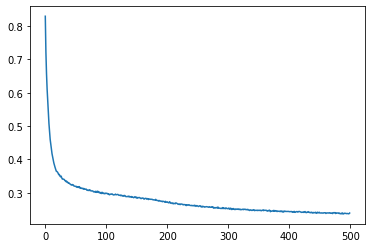

In [27]:
plt.plot(range(epochs), losses)

In [30]:
# TO EVALUATE THE ENTIRE TEST SET
with torch.no_grad():
    if CUDA:
        y_test = y_test.cuda()
        cat_test = cat_test.cuda()
        con_test = con_test.cuda()
    y_val = model(cat_test, con_test)
    loss = criterion(y_val, y_test)
print(f'RMSE: {loss:.8f}')

RMSE: 0.23992838


In [57]:
for i in range(50):
    print(f"{i}) PREDICTED : {y_val[i].argmax().item()}. TRUE : {y_test[i].item()}.")

0) PREDICTED : 0. TRUE : 0.
1) PREDICTED : 1. TRUE : 0.
2) PREDICTED : 0. TRUE : 0.
3) PREDICTED : 1. TRUE : 1.
4) PREDICTED : 0. TRUE : 0.
5) PREDICTED : 0. TRUE : 0.
6) PREDICTED : 0. TRUE : 0.
7) PREDICTED : 1. TRUE : 1.
8) PREDICTED : 0. TRUE : 0.
9) PREDICTED : 1. TRUE : 1.
10) PREDICTED : 0. TRUE : 0.
11) PREDICTED : 0. TRUE : 0.
12) PREDICTED : 0. TRUE : 0.
13) PREDICTED : 1. TRUE : 1.
14) PREDICTED : 0. TRUE : 0.
15) PREDICTED : 1. TRUE : 1.
16) PREDICTED : 0. TRUE : 1.
17) PREDICTED : 0. TRUE : 0.
18) PREDICTED : 0. TRUE : 0.
19) PREDICTED : 0. TRUE : 0.
20) PREDICTED : 1. TRUE : 1.
21) PREDICTED : 1. TRUE : 1.
22) PREDICTED : 1. TRUE : 1.
23) PREDICTED : 1. TRUE : 1.
24) PREDICTED : 1. TRUE : 1.
25) PREDICTED : 0. TRUE : 0.
26) PREDICTED : 0. TRUE : 0.
27) PREDICTED : 0. TRUE : 0.
28) PREDICTED : 1. TRUE : 1.
29) PREDICTED : 0. TRUE : 0.
30) PREDICTED : 0. TRUE : 0.
31) PREDICTED : 1. TRUE : 1.
32) PREDICTED : 1. TRUE : 1.
33) PREDICTED : 1. TRUE : 1.
34) PREDICTED : 0. TRUE 

In [66]:
print(float((y_val.argmax(axis=1) == y_test).sum())/y_test.shape[0])

0.9125
